# Behavior Cloningを使用して実機の自動運転の学習をしたい。
学習データは、自分が運転したデータを使用する。
データの形式は、画像とその時の操作であるsteeringとthrottleの値が保存されている。


In [1]:
import numpy as np
import gymnasium
from gymnasium.wrappers import TimeLimit
from imitation.data import rollout
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

from gymnasium.spaces import Box
from gymnasium.envs.registration import register
import racing_gym
import os
import json
from PIL import Image
import torch
import time


## 環境を事務のレジストリに追加する

In [2]:
gymnasium.register(
    id = 'RacingEnv-v0',
    entry_point = 'racing_gym.envs.racing_env:RacingEnv',
    max_episode_steps = 1000,
)
gymnasium.register(
    id = 'RacingEnv-v1',
    entry_point = 'racing_gym.envs.racing_env1:RacingEnv1',
    max_episode_steps = 1000,
)
gymnasium.register(
    id = 'RacingEnv-v2',
    entry_point = 'racing_gym.envs.racing_env2:RacingEnv2',
    max_episode_steps = 1000,
)

/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RacingEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RacingEnv-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RacingEnv-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


ベクトル化された環境を作成する

In [4]:
import os
import json
import numpy as np
from PIL import Image

def load_expert_data(data_path):
    # expert_dataの初期化
    expert_data = {'images': [], 'actions': []}
    # print(expert_data)
    # count = 0

    # 画像ファイルに対応するJSONファイルを取得
    json_file_list = [json_file for json_file in os.listdir(data_path) if json_file.startswith('record_') and json_file.endswith('.json')]
    # print(len(json_file_list))

    for json_file in json_file_list:
        # count += 1
        # print(count)
        # print(json_file)

        # レコードのファイルパスを構築
        json_path = os.path.join(data_path, json_file)
        # print(json_path)

        # レコードの読み込み
        try:
            with open(json_path, 'r') as json_file:
                record_data = json.load(json_file)
        except FileNotFoundError:
            print(f"エラー：{json_path} でJSONファイルが見つかりませんでした。")
            continue
        except json.JSONDecodeError:
            print(f"エラー：{json_path} のJSONファイルのデコードに失敗しました。")
            continue

        # 画像データの読み込み
        image_file = record_data.get('cam/image_array', '')  # 画像ファイル名をJSONから取得
        # print(image_file)
        image_path = os.path.join(data_path, image_file)
        # print(image_path)
        try:
            image_data = np.array(Image.open(image_path))
        except FileNotFoundError:
            print(f"エラー：{image_path} で画像ファイルが見つかりませんでした。")
            continue

        # expert_dataに追加
        expert_data['images'].append(image_data)
        expert_data['actions'].append([record_data.get('user/angle', 0), record_data.get('user/throttle', 0)])

    return expert_data


In [234]:
a = expert_data['actions'][3]
print(expert_data['actions'][3])
print(a[0])

actions = expert_data['actions']
steer = [action[0] for action in expert_data['actions']]
throttel = [action[1] for action in expert_data['actions']]
print("Min actions:", np.min(steer))
print("Max actions:", np.max(steer))
print(steer)
print("Min throttel:", np.min(throttel))
print("Max throttel:", np.max(throttel))
print(throttel)

[1.0, 0.7]
1.0
Min actions: -1.0
Max actions: 1.0
[1.0, 1.0, 1.0, 1.0, 0.0, 0.5360881374553667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0,

In [5]:
# expert_data_path = '../../Data/autorace/O/tub_9_24-01-09'
expert_data_path = '../../autorace/data/tub_9_24-01-09'
expert_data = load_expert_data(expert_data_path)
print(expert_data['images'][0].shape)
reshaped_expert_data = expert_data
# すべての画像を変換
for i in range(len(reshaped_expert_data['images'])):
    # 画像の軸の順序を変更
    reshaped_image = np.transpose(reshaped_expert_data['images'][i], (2, 0, 1))
    
    # expert_dataに変更を反映
    reshaped_expert_data['images'][i] = reshaped_image

# 形状を確認
print(reshaped_expert_data['images'][0].shape)

for i in range(len(reshaped_expert_data['images'])):
    if reshaped_expert_data['images'][i].shape != (3, 224, 224):
        print(i)



(224, 224, 3)
(3, 224, 224)


In [5]:
# expert_data_path = '../../Data/autorace/O/tub_9_24-01-09'
expert_data_path = '../../autorace/data/tub_9_24-01-09'
expert_data = load_expert_data(expert_data_path)
# reshaped_expert_data = 
print(expert_data['actions'])
env = gymnasium.make('RacingEnv-v0', expert_data=expert_data)
env1 = gymnasium.make('RacingEnv-v1', expert_data=reshaped_expert_data)

[[1.0, 0.7], [1.0, 0.8], [1.0, 0.8], [1.0, 0.7], [0.0, 0.8], [0.5360881374553667, 0.8], [1.0, 0.7], [1.0, 0.8], [1.0, 0.7], [1.0, 0.8], [1.0, 0.65], [1.0, 0.7], [0.0, 0.8], [0.0, 0.8], [0.0, 0.8], [1.0, 0.65], [1.0, 0.8], [1.0, 0.65], [0.0, 0.65], [0.0, 0.7], [0.0, 0.65], [1.0, 0.8], [0.0, -0.0], [0.0, 0.7], [1.0, 0.65], [1.0, 0.8], [1.0, 0.65], [0.0, 0.7], [1.0, 0.65], [1.0, 0.8], [1.0, 0.8], [1.0, 0.7], [0.0, 0.7], [1.0, 0.8], [0.0, 0.65], [0.0, 0.8], [0.0, 0.8], [1.0, 0.8], [1.0, 0.7], [1.0, 0.8], [1.0, 0.8], [1.0, 0.8], [0.0, 0.7], [1.0, 0.8], [0.0, 0.65], [1.0, 0.65], [1.0, 0.65], [0.0, 0.8], [0.0, 0.8], [0.0, 0.8], [0.0, 0.7], [1.0, 0.65], [0.0, 0.8], [0.0, 0.65], [0.0, 0.8], [0.0, 0.8], [1.0, 0.65], [1.0, 0.8], [0.0, 0.65], [0.0, 0.8], [0.0, 0.65], [1.0, 0.8], [1.0, 0.8], [1.0, 0.8], [1.0, 0.65], [1.0, 0.65], [1.0, 0.65], [1.0, 0.8], [0.0, 0.65], [1.0, 0.65], [0.0, 0.65], [1.0, 0.7], [1.0, 0.7], [1.0, 0.8], [0.0, 0.8], [1.0, 0.65], [1.0, 0.65], [0.0, 0.8], [1.0, 0.8], [1.0, 0.8]

/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v0 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(
/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v1 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(


In [6]:
env_id2 = 'RacingEnv-v2'
try:
    env2 = gymnasium.make(env_id2)
    print(f"Environment '{env_id2}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")

Environment 'RacingEnv-v2' is successfully registered.


In [170]:
# env = gym.make('RacingEnv-v0')

# print(list(gym.envs.registry.keys()))
# print(env.expert_data)

In [171]:
import gymnasium
env_id = 'RacingEnv-v0'  # あなたの環境の名前に変更してください
try:
    env = gymnasium.make(env_id, expert_data=expert_data)
    print(f"Environment '{env_id}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")
env_id1 = 'RacingEnv-v1'  # あなたの環境の名前に変更してください
try:
    env1 = gymnasium.make(env_id1, expert_data=expert_data)
    print(f"Environment '{env_id1}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")

Environment 'RacingEnv-v0' is successfully registered.
Environment 'RacingEnv-v1' is successfully registered.


In [7]:
venv2 = make_vec_env(
    "RacingEnv-v2",
    rng = np.random.default_rng(),
    n_envs = 4,
    post_wrappers = [lambda env2, _: RolloutInfoWrapper(env2)],
)

In [8]:
def _make_env():
    """Helper function to create a single environment. Put any logic here, but make sure to return a RolloutInfoWrapper."""
    _env = gymnasium.make("RacingEnv-v0", expert_data=expert_data)
    _env = RolloutInfoWrapper(_env)
    return _env

venv = DummyVecEnv([_make_env for _ in range(4)])

def _make_env():
    """Helper function to create a single environment. Put any logic here, but make sure to return a RolloutInfoWrapper."""
    _env1 = gymnasium.make("RacingEnv-v1", expert_data=reshaped_expert_data)
    _env1 = RolloutInfoWrapper(_env1)
    return _env1

venv1 = DummyVecEnv([_make_env for _ in range(4)])

In [10]:

# # 環境の初期化
# env = gymnasium.make("RacingEnv-v0", expert_data=expert_data)

# num_episodes = 1000

# # 学習ループなどで利用
# # for _ in range(num_episodes):
# #     action = policy.predict(observation)  # ポリシーによるアクション予測
# #     observation, reward, done, info = env.step(action)
# #     if done:
# #         observation = env.reset()

# env.reset()
# next_state, reward, done, trunc, info = env.step(action=[0, 0])
# print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

In [11]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

model = PPO(MlpPolicy, venv, verbose=1)


# 観測空間の形状を確認
obs_shape = model.observation_space.shape
print(f"Observation space shape: {obs_shape}")

Using cuda device
Wrapping the env in a VecTransposeImage.
Observation space shape: (3, 224, 224)


In [160]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy

expert = PPO(
    policy=MlpPolicy,
    env=env1,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
)
reward, _ = evaluate_policy(expert, env1, 10)
print(f"Reward before training: {reward}")


# Note: if you followed step 2a, i.e. registered the environment, you can use the environment name directly

# expert = PPO(
#     policy=MlpPolicy,
#     env="custom/ObservationMatching-v0",
#     seed=0,
#     batch_size=64,
#     ent_coef=0.0,
#     learning_rate=0.0003,
#     n_epochs=10,
#     n_steps=64,
# )
expert.learn(10000)  # Note: set to 100000 to train a proficient expert
reward, _ = evaluate_policy(expert, expert.get_env(), 10)
print(f"Expert reward: {reward}")

/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward before training: 552.7326119542122
Expert reward: 728.176206


In [142]:
from typing import List
ACTION_NAME: List[str] = ['steer', 'throttle']
weight = {
    'steer': 1.0,
    'throttle': 1.0
}
def calculate_reward(action, current_expert_data):
    # MSEを使用する
    reward = 0
    count = 0 
    for i, action_name in enumerate(ACTION_NAME):
        count += 1
        reward += weight[action_name] * (action[i] - current_expert_data[i]) ** 2
    print(count)
    return 1/(reward+1)

action = transitions[1232]['acts']
current_expert_data = expert_data['actions'][12]
calculate_reward(action, current_expert_data)

2


0.5367880615422704

In [13]:
print(expert.get_env().observation_space)
print(env.observation_space)
print(env1.observation_space)
print(env2.observation_space)
print(venv.observation_space)
print(venv1.observation_space)
print(venv2.observation_space)

Box(0, 255, (3, 224, 224), uint8)
Box(0, 255, (224, 224, 3), uint8)
Box(0, 255, (3, 224, 224), uint8)
Box(0, 255, (224, 224, 3), uint8)
Box(0, 255, (224, 224, 3), uint8)
Box(0, 255, (3, 224, 224), uint8)
Box(0, 255, (224, 224, 3), uint8)


In [10]:
rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    venv1,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)

In [29]:
def policy_demo(policy):
    # 環境の初期化
    env = gymnasium.make("RacingEnv-v0", expert_data=expert_data)

    # 環境のリセット
    observation = env.reset()

    # エピソードのループ
    for i in range(1000):
        # アクションの予測
        action, _ = policy.predict(observation, deterministic=True)

        # 環境のステップを実行
        observation, reward, done, info = env.step(action)

        # 終了判定
        if done:
            print("Episode finished after {} timesteps".format(i + 1))
            break

your_observation = transitions[0]['obs']
# モデルの出力を計算
with torch.no_grad():
    observation_tensor = torch.tensor(your_observation, dtype=torch.float32).unsqueeze(0).to("cuda")
    
    # 計測開始
    start = time.time()

    predicted_action1 = expert.policy(observation_tensor)
    predicted_action2 = expert.predict(your_observation)
    
    # 計測終了
    end = time.time()

print("Predicted Action:", predicted_action1)
print("Predicted Action:", predicted_action2)

predicted_action1 = predicted_action1[0].cpu().numpy()
predicted_action2 = predicted_action2[0]

print("Predicted Action:", predicted_action1)
print("Predicted Action:", predicted_action2)

# 計測時間を表示 (hz: 1秒間に何回処理が実行されたか)
print(f"Time: {end - start}")
print(f"Hz: {1 / (end - start)}")

Predicted Action: (tensor([[ 1.4942, -1.7506]], device='cuda:0'), tensor([[22.0067]], device='cuda:0'), tensor([-5.0540], device='cuda:0'))
Predicted Action: (array([-0.73350257,  0.        ], dtype=float32), None)
Predicted Action: [[ 1.4942307 -1.7505597]]
Predicted Action: [-0.73350257  0.        ]
Time: 0.0015642642974853516
Hz: 639.2781588172535


In [122]:
print(len(transitions))
count = 0
my_list = []
# for i in range(len(transitions)-2):
#     if np.all(transitions[999]['next_obs'] == transitions[i+1]['next_obs']):
#         count += 1
#         my_list.append(i)
# print(len(my_list))
# for i in range(len(transitions)):
#     actions = transitions[i]['acts']

for i in range(len(expert_data)):
    actions = expert_data['actions'][i]


steer = [action[0] for action in expert_data['actions']]
throttel = [action[1] for action in expert_data['actions']]
print("Min steer:", np.min(steer))
print("Max steer:", np.max(steer))
# print(steer)
print("Min throttel:", np.min(throttel))
print("Max throttel:", np.max(throttel))
# print(throttel)

52000
Min steer: -1.0
Max steer: 1.0
Min throttel: -0.0
Max throttel: 0.8


In [152]:
print(transitions[0]['acts'].shape)
print(env1.action_space.shape)
print(bc_trainer.policy.action_space.low)
print(bc_trainer.policy.action_space.high)
print(transitions[0]['obs'].shape)
print(env1.observation_space.shape)
print(bc_trainer.observation_space.shape)

(2,)
(2,)
[-1.  0.]
[1. 1.]
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


In [30]:
from imitation.algorithms import bc
from imitation.util import logger

bc_logger = logger.configure('./log/')
bc_trainer = bc.BC(
    observation_space=env1.observation_space,
    action_space=env1.action_space,
    demonstrations=transitions,
    rng=rng,
    batch_size=4096,
    device="cuda",
    custom_logger=bc_logger
)

In [31]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward before training: {reward_before_training}")

/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward before training: 552.7041733264923


In [32]:
bc_trainer.train(n_epochs=100, log_interval=24)
reward_after_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward after training: {reward_after_training}")

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00284 |
|    entropy        | 2.84     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 129      |
|    loss           | 2.27     |
|    neglogp        | 2.27     |
|    prob_true_act  | 0.108    |
|    samples_so_far | 4096     |
--------------------------------


24batch [00:08,  2.78batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 24       |
|    ent_loss       | -0.00279 |
|    entropy        | 2.79     |
|    epoch          | 2        |
|    l2_loss        | 0        |
|    l2_norm        | 203      |
|    loss           | 2.14     |
|    neglogp        | 2.15     |
|    prob_true_act  | 0.12     |
|    samples_so_far | 102400   |
--------------------------------


48batch [00:17,  2.81batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 48       |
|    ent_loss       | -0.00274 |
|    entropy        | 2.74     |
|    epoch          | 4        |
|    l2_loss        | 0        |
|    l2_norm        | 214      |
|    loss           | 2.11     |
|    neglogp        | 2.11     |
|    prob_true_act  | 0.125    |
|    samples_so_far | 200704   |
--------------------------------


72batch [00:25,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 72       |
|    ent_loss       | -0.00269 |
|    entropy        | 2.69     |
|    epoch          | 6        |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 2.09     |
|    neglogp        | 2.09     |
|    prob_true_act  | 0.127    |
|    samples_so_far | 299008   |
--------------------------------


96batch [00:34,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 96       |
|    ent_loss       | -0.00265 |
|    entropy        | 2.65     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 2.06     |
|    neglogp        | 2.06     |
|    prob_true_act  | 0.132    |
|    samples_so_far | 397312   |
--------------------------------


120batch [00:42,  2.80batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 120      |
|    ent_loss       | -0.0026  |
|    entropy        | 2.6      |
|    epoch          | 10       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 2.03     |
|    neglogp        | 2.03     |
|    prob_true_act  | 0.135    |
|    samples_so_far | 495616   |
--------------------------------


144batch [00:51,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 144      |
|    ent_loss       | -0.00256 |
|    entropy        | 2.56     |
|    epoch          | 12       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 2        |
|    neglogp        | 2.01     |
|    prob_true_act  | 0.14     |
|    samples_so_far | 593920   |
--------------------------------


168batch [00:59,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 168      |
|    ent_loss       | -0.00251 |
|    entropy        | 2.51     |
|    epoch          | 14       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.98     |
|    neglogp        | 1.98     |
|    prob_true_act  | 0.143    |
|    samples_so_far | 692224   |
--------------------------------


192batch [01:08,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 192      |
|    ent_loss       | -0.00247 |
|    entropy        | 2.47     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.96     |
|    neglogp        | 1.96     |
|    prob_true_act  | 0.147    |
|    samples_so_far | 790528   |
--------------------------------


216batch [01:17,  2.78batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 216      |
|    ent_loss       | -0.00243 |
|    entropy        | 2.43     |
|    epoch          | 18       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.94     |
|    neglogp        | 1.94     |
|    prob_true_act  | 0.15     |
|    samples_so_far | 888832   |
--------------------------------


240batch [01:25,  2.82batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 240      |
|    ent_loss       | -0.00239 |
|    entropy        | 2.39     |
|    epoch          | 20       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.91     |
|    neglogp        | 1.91     |
|    prob_true_act  | 0.156    |
|    samples_so_far | 987136   |
--------------------------------


264batch [01:34,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 264      |
|    ent_loss       | -0.00235 |
|    entropy        | 2.35     |
|    epoch          | 22       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.9      |
|    neglogp        | 1.9      |
|    prob_true_act  | 0.158    |
|    samples_so_far | 1085440  |
--------------------------------


288batch [01:42,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 288      |
|    ent_loss       | -0.00232 |
|    entropy        | 2.32     |
|    epoch          | 24       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.88     |
|    neglogp        | 1.88     |
|    prob_true_act  | 0.161    |
|    samples_so_far | 1183744  |
--------------------------------


312batch [01:51,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 312      |
|    ent_loss       | -0.00228 |
|    entropy        | 2.28     |
|    epoch          | 26       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.85     |
|    neglogp        | 1.85     |
|    prob_true_act  | 0.166    |
|    samples_so_far | 1282048  |
--------------------------------


336batch [01:59,  2.81batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 336      |
|    ent_loss       | -0.00225 |
|    entropy        | 2.25     |
|    epoch          | 28       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.85     |
|    neglogp        | 1.85     |
|    prob_true_act  | 0.168    |
|    samples_so_far | 1380352  |
--------------------------------


360batch [02:08,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 360      |
|    ent_loss       | -0.00222 |
|    entropy        | 2.22     |
|    epoch          | 30       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.82     |
|    neglogp        | 1.83     |
|    prob_true_act  | 0.172    |
|    samples_so_far | 1478656  |
--------------------------------


384batch [02:16,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 384      |
|    ent_loss       | -0.00218 |
|    entropy        | 2.18     |
|    epoch          | 32       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.8      |
|    neglogp        | 1.81     |
|    prob_true_act  | 0.176    |
|    samples_so_far | 1576960  |
--------------------------------


408batch [02:25,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 408      |
|    ent_loss       | -0.00215 |
|    entropy        | 2.15     |
|    epoch          | 34       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.79     |
|    neglogp        | 1.79     |
|    prob_true_act  | 0.179    |
|    samples_so_far | 1675264  |
--------------------------------


432batch [02:33,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 432      |
|    ent_loss       | -0.00213 |
|    entropy        | 2.13     |
|    epoch          | 36       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.79     |
|    neglogp        | 1.79     |
|    prob_true_act  | 0.18     |
|    samples_so_far | 1773568  |
--------------------------------


456batch [02:42,  2.81batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 456      |
|    ent_loss       | -0.0021  |
|    entropy        | 2.1      |
|    epoch          | 38       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.77     |
|    neglogp        | 1.78     |
|    prob_true_act  | 0.183    |
|    samples_so_far | 1871872  |
--------------------------------


480batch [02:50,  2.80batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 480      |
|    ent_loss       | -0.00207 |
|    entropy        | 2.07     |
|    epoch          | 40       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.76     |
|    neglogp        | 1.76     |
|    prob_true_act  | 0.185    |
|    samples_so_far | 1970176  |
--------------------------------


504batch [02:59,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 504      |
|    ent_loss       | -0.00205 |
|    entropy        | 2.05     |
|    epoch          | 42       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.75     |
|    neglogp        | 1.75     |
|    prob_true_act  | 0.188    |
|    samples_so_far | 2068480  |
--------------------------------


528batch [03:08,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 528      |
|    ent_loss       | -0.00202 |
|    entropy        | 2.02     |
|    epoch          | 44       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.75     |
|    neglogp        | 1.75     |
|    prob_true_act  | 0.189    |
|    samples_so_far | 2166784  |
--------------------------------


552batch [03:16,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 552      |
|    ent_loss       | -0.002   |
|    entropy        | 2        |
|    epoch          | 46       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.72     |
|    neglogp        | 1.73     |
|    prob_true_act  | 0.193    |
|    samples_so_far | 2265088  |
--------------------------------


576batch [03:25,  2.80batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 576      |
|    ent_loss       | -0.00198 |
|    entropy        | 1.98     |
|    epoch          | 48       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.72     |
|    neglogp        | 1.73     |
|    prob_true_act  | 0.194    |
|    samples_so_far | 2363392  |
--------------------------------


600batch [03:33,  2.79batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 600      |
|    ent_loss       | -0.00196 |
|    entropy        | 1.96     |
|    epoch          | 50       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.72     |
|    neglogp        | 1.72     |
|    prob_true_act  | 0.195    |
|    samples_so_far | 2461696  |
--------------------------------


624batch [03:42,  2.76batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 624      |
|    ent_loss       | -0.00194 |
|    entropy        | 1.94     |
|    epoch          | 52       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.72     |
|    neglogp        | 1.72     |
|    prob_true_act  | 0.196    |
|    samples_so_far | 2560000  |
--------------------------------


648batch [03:51,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 648      |
|    ent_loss       | -0.00192 |
|    entropy        | 1.92     |
|    epoch          | 54       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.71     |
|    neglogp        | 1.71     |
|    prob_true_act  | 0.199    |
|    samples_so_far | 2658304  |
--------------------------------


672batch [03:59,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 672      |
|    ent_loss       | -0.0019  |
|    entropy        | 1.9      |
|    epoch          | 56       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.71     |
|    neglogp        | 1.71     |
|    prob_true_act  | 0.198    |
|    samples_so_far | 2756608  |
--------------------------------


696batch [04:08,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 696      |
|    ent_loss       | -0.00189 |
|    entropy        | 1.89     |
|    epoch          | 58       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.68     |
|    neglogp        | 1.69     |
|    prob_true_act  | 0.203    |
|    samples_so_far | 2854912  |
--------------------------------


720batch [04:17,  2.78batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 720      |
|    ent_loss       | -0.00187 |
|    entropy        | 1.87     |
|    epoch          | 60       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.67     |
|    neglogp        | 1.67     |
|    prob_true_act  | 0.206    |
|    samples_so_far | 2953216  |
--------------------------------


744batch [04:25,  2.81batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 744      |
|    ent_loss       | -0.00186 |
|    entropy        | 1.86     |
|    epoch          | 62       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.67     |
|    neglogp        | 1.67     |
|    prob_true_act  | 0.207    |
|    samples_so_far | 3051520  |
--------------------------------


768batch [04:34,  2.81batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 768      |
|    ent_loss       | -0.00184 |
|    entropy        | 1.84     |
|    epoch          | 64       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.68     |
|    neglogp        | 1.69     |
|    prob_true_act  | 0.204    |
|    samples_so_far | 3149824  |
--------------------------------


792batch [04:42,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 792      |
|    ent_loss       | -0.00183 |
|    entropy        | 1.83     |
|    epoch          | 66       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.68     |
|    neglogp        | 1.68     |
|    prob_true_act  | 0.206    |
|    samples_so_far | 3248128  |
--------------------------------


816batch [04:51,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 816      |
|    ent_loss       | -0.00181 |
|    entropy        | 1.81     |
|    epoch          | 68       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.67     |
|    neglogp        | 1.67     |
|    prob_true_act  | 0.208    |
|    samples_so_far | 3346432  |
--------------------------------


840batch [05:00,  2.78batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 840      |
|    ent_loss       | -0.0018  |
|    entropy        | 1.8      |
|    epoch          | 70       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.67     |
|    neglogp        | 1.67     |
|    prob_true_act  | 0.208    |
|    samples_so_far | 3444736  |
--------------------------------


864batch [05:08,  2.76batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 864      |
|    ent_loss       | -0.00179 |
|    entropy        | 1.79     |
|    epoch          | 72       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.67     |
|    neglogp        | 1.67     |
|    prob_true_act  | 0.208    |
|    samples_so_far | 3543040  |
--------------------------------


888batch [05:17,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 888      |
|    ent_loss       | -0.00178 |
|    entropy        | 1.78     |
|    epoch          | 74       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.66     |
|    neglogp        | 1.66     |
|    prob_true_act  | 0.21     |
|    samples_so_far | 3641344  |
--------------------------------


912batch [05:25,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 912      |
|    ent_loss       | -0.00177 |
|    entropy        | 1.77     |
|    epoch          | 76       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.65     |
|    neglogp        | 1.65     |
|    prob_true_act  | 0.213    |
|    samples_so_far | 3739648  |
--------------------------------


936batch [05:34,  2.79batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 936      |
|    ent_loss       | -0.00176 |
|    entropy        | 1.76     |
|    epoch          | 78       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.64     |
|    neglogp        | 1.64     |
|    prob_true_act  | 0.216    |
|    samples_so_far | 3837952  |
--------------------------------


960batch [05:43,  2.82batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 960      |
|    ent_loss       | -0.00175 |
|    entropy        | 1.75     |
|    epoch          | 80       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.65     |
|    neglogp        | 1.65     |
|    prob_true_act  | 0.213    |
|    samples_so_far | 3936256  |
--------------------------------


984batch [05:52,  2.77batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 984      |
|    ent_loss       | -0.00174 |
|    entropy        | 1.74     |
|    epoch          | 82       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.65     |
|    neglogp        | 1.65     |
|    prob_true_act  | 0.213    |
|    samples_so_far | 4034560  |
--------------------------------


1008batch [06:00,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1008     |
|    ent_loss       | -0.00173 |
|    entropy        | 1.73     |
|    epoch          | 84       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.63     |
|    neglogp        | 1.64     |
|    prob_true_act  | 0.217    |
|    samples_so_far | 4132864  |
--------------------------------


1032batch [06:09,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1032     |
|    ent_loss       | -0.00172 |
|    entropy        | 1.72     |
|    epoch          | 86       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.65     |
|    neglogp        | 1.65     |
|    prob_true_act  | 0.213    |
|    samples_so_far | 4231168  |
--------------------------------


1056batch [06:18,  2.80batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1056     |
|    ent_loss       | -0.00172 |
|    entropy        | 1.72     |
|    epoch          | 88       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.64     |
|    neglogp        | 1.64     |
|    prob_true_act  | 0.216    |
|    samples_so_far | 4329472  |
--------------------------------


1080batch [06:26,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1080     |
|    ent_loss       | -0.00171 |
|    entropy        | 1.71     |
|    epoch          | 90       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.64     |
|    neglogp        | 1.64     |
|    prob_true_act  | 0.216    |
|    samples_so_far | 4427776  |
--------------------------------


1104batch [06:35,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1104     |
|    ent_loss       | -0.0017  |
|    entropy        | 1.7      |
|    epoch          | 92       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.64     |
|    neglogp        | 1.65     |
|    prob_true_act  | 0.215    |
|    samples_so_far | 4526080  |
--------------------------------


1128batch [06:43,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1128     |
|    ent_loss       | -0.0017  |
|    entropy        | 1.7      |
|    epoch          | 94       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.65     |
|    neglogp        | 1.65     |
|    prob_true_act  | 0.215    |
|    samples_so_far | 4624384  |
--------------------------------


1152batch [06:52,  2.82batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1152     |
|    ent_loss       | -0.00169 |
|    entropy        | 1.69     |
|    epoch          | 96       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.64     |
|    neglogp        | 1.65     |
|    prob_true_act  | 0.216    |
|    samples_so_far | 4722688  |
--------------------------------


1176batch [07:00,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1176     |
|    ent_loss       | -0.00169 |
|    entropy        | 1.69     |
|    epoch          | 98       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.64     |
|    neglogp        | 1.64     |
|    prob_true_act  | 0.217    |
|    samples_so_far | 4820992  |
--------------------------------


1200batch [07:09,  2.79batch/s]


Reward after training: 692.4362139701843


In [37]:
# read csv
with open('./log/progress.csv', 'r') as f:
    
    # read header
    header = f.readline().strip().split(',')
    print(header)
    
    # read data
    data = []
    for line in f:
        data.append(list(map(float, line.strip().split(','))))
    data = np.array(data)
    print(data.shape)

['bc/samples_so_far', 'bc/l2_loss', 'bc/ent_loss', 'bc/l2_norm', 'bc/prob_true_act', 'bc/epoch', 'bc/loss', 'bc/batch', 'bc/neglogp', 'batch_size', 'bc/entropy']
(50, 11)


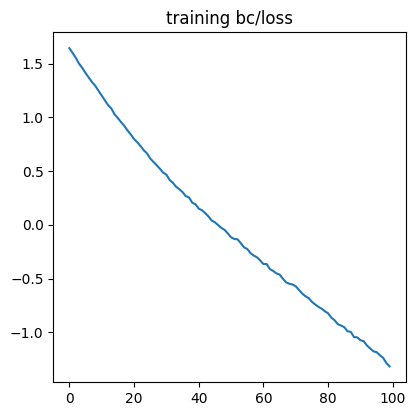

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(data[:, 9])
plt.title("training bc/loss")
plt.show()

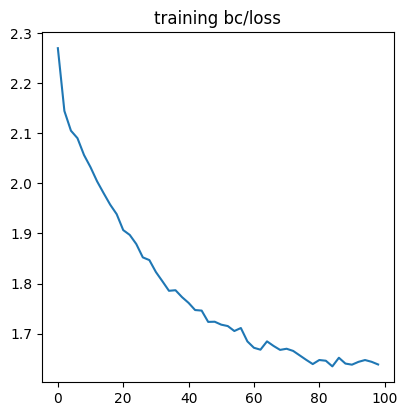

In [40]:
# # read csv
# with open('./log/progress.csv', 'r') as f:
    
#     # read header
#     header = f.readline().strip().split(',')
#     print(header)
    
#     # read data
#     data = []
#     for line in f:
#         data.append(list(map(float, line.strip().split(','))))
#     data = np.array(data)
#     print(data.shape)

import matplotlib.pyplot as plt

y_data = data[:, 6]
x_data = range(0, len(y_data)*2, 2)
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
# plt.plot(data[:, 9])
plt.plot(x_data, y_data)
plt.title("training bc/loss")
plt.show()

作成したログの名前を変更する

In [41]:
import os

# 新しいファイル名
new_csv_filename = './log/progress_24-01-26_e100_norm.csv'
new_txt_filename = './log/log_24-01-26_e100_norm.txt'

# 旧ファイル名から新ファイル名への変更
os.rename('./log/progress.csv', new_csv_filename)
os.rename('./log/log.txt', new_txt_filename)


In [206]:
import numpy as np

# 報酬（reward）の範囲を確認する
rewards = [entry['acts'] for entry in transitions]
print("Min Reward:", np.min(rewards))
print("Max Reward:", np.max(rewards))


Min Reward: 0.0
Max Reward: 1.0


In [207]:
print(rewards[2334])

[1. 1.]


In [38]:
import torch
import numpy as np
import time
from torchvision import transforms
from imitation.data import types
from imitation.util import util

# 連続値の観測空間の場合、ランダムなデータを生成
# your_observation = np.random.uniform(low=env1.observation_space.low, high=env1.observation_space.high, size=env1.observation_space.shape)
# your_observation = transitions[0]['obs']
your_observation = reshaped_expert_data['images'][0]
print(your_observation.shape)
# # 前処理の定義
# preprocess = transforms.Compose([
#     transforms.Resize((224, 224)),  # サイズの調整
#     transforms.ToTensor(),          # テンソルに変換
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 正規化
# ])
# # NumPy配列に変換してからPIL Imageに変換
# your_observation_array = (your_observation * 255).astype(np.uint8).transpose((1, 2, 0))
# your_observation_image = Image.fromarray(your_observation_array)

# # 画像に前処理を適用
# processed_image = preprocess(your_observation_image)


# # モデルの出力を計算
# with torch.no_grad():
#     # 計測開始
#     start = time.time()

#     observation_tensor = torch.tensor(your_observation, dtype=torch.float32).unsqueeze(0).to("cuda")
    
#     predicted_action1 = bc_trainer.policy(observation_tensor)
#     predicted_action2 = recon_bc(observation_tensor)
    
#     # 計測終了
#     end = time.time()

# 計測開始
start = time.time()

# predicted_action1 = bc_trainer.policy.predict(your_observation)
predicted_action2 = recon_bc.predict(your_observation)

# 計測終了
end = time.time()


# print("Predicted Action:", predicted_action1)
print("Predicted Action:", predicted_action2)

# predicted_action1 = predicted_action1[0]
predicted_action2 = predicted_action2[0]

# print("Predicted Action:", predicted_action1)
print("Predicted Action:", predicted_action2)

# 計測時間を表示 (hz: 1秒間に何回処理が実行されたか)
print(f"Time: {end - start}")
print(f"Hz: {1 / (end - start)}")

# print(env1.action_space.shape)
# print(predicted_action1.shape)

(3, 224, 224)
Predicted Action: (array([0.7025346, 0.5962367], dtype=float32), None)
Predicted Action: [0.7025346 0.5962367]
Time: 0.0013661384582519531
Hz: 731.9902268760908


In [169]:
bc_trainer.policy.save('./model/bc_trainer_policy.zip')
bc_trainer.policy.load('./model/bc_trainer_policy.zip')

In [170]:
from imitation.util import util
util.save_policy(bc_trainer.policy, './model/bc_trainer_policy')

In [34]:
from imitation.algorithms import bc
recon_bc = bc.reconstruct_policy('./model/bc_trainer_policy_24-01-26_e1000', device='cuda')

In [168]:
print(observation_tensor.shape)
print(your_observation.shape)

torch.save(bc_trainer.policy.state_dict(), './model/bc_trainer_policy.pth')

torch.Size([1, 224, 224, 3])
(3, 224, 224)


In [166]:
import torch
from torch2trt import torch2trt
# 学習済みのBCモデルを保存
torch.save(bc_trainer.policy.state_dict(), './model/bc_trainer_policy.pth')

# 保存したpthファイルをtrtファイルに変換
dummy_input = torch.randn(1, 3, 224, 224).cuda()
trt_model = torch2trt(bc_trainer.policy, [dummy_input], fp16_mode=True)
# trt_model = torch2trt(bc_trainer.policy, [dummy_input], fp16_mode=True, max_workspace_size=1<<25)

observation_tensor = torch.tensor(your_observation, dtype=torch.float32)
observation_tensor = observation_tensor.unsqueeze(0)
action = trt_model(observation_tensor)
print(action)

ModuleNotFoundError: No module named 'torch2trt'